最大勝率増加:
チーム: 読売ジャイアンツ, 年度: 1975
勝率の変化: 0.246

最大勝率減少:
チーム: 松竹ロビンス, 年度: 1950
勝率の変化: -0.255


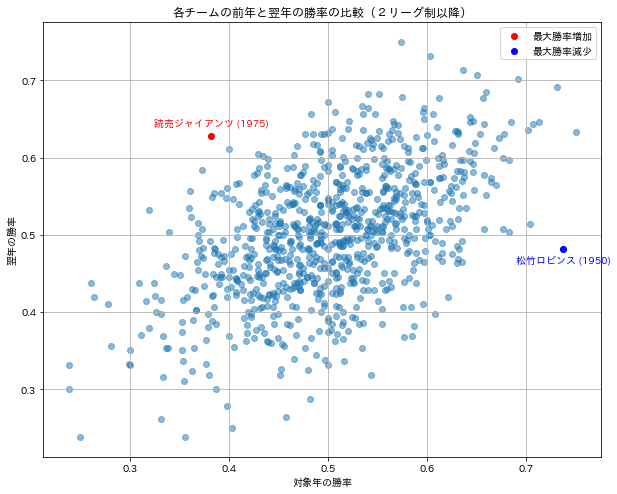

In [3]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

# データベース接続情報を設定してください
DB_HOST = '54.150.30.249'
DB_PORT = '5432'
DB_NAME = 'npb'
DB_USER = 'rdsuser'
DB_PASSWORD = 'rds%5678'

# データベースに接続
conn = psycopg2.connect(
    host=DB_HOST,
    port=DB_PORT,
    database=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD
)

# クエリを実行してデータを取得
query = """
SELECT
    s.team_id,
    s.season_id,
    seasons.year,
    s.winning_percentage,
    th.team_name
FROM
    Standings s
JOIN
    Seasons seasons ON s.season_id = seasons.season_id
JOIN
    team_history th ON s.team_id = th.team_id
    AND seasons.start_date BETWEEN th.start_date AND COALESCE(th.end_date, '9999-12-31')
ORDER BY
    s.team_id, seasons.year;
"""

df = pd.read_sql_query(query, conn)

# 接続を閉じる
conn.close()

# データの整形
# 重複するチーム名を避けるため、最新のチーム名のみを使用
df = df.drop_duplicates(subset=['team_id', 'year'], keep='last')

# 各チームごとに前年と翌年の勝率を取得
df['next_year'] = df['year'] + 1
df_next = df[['team_id', 'year', 'winning_percentage']].copy()
df_next.columns = ['team_id', 'year', 'winning_percentage_next']

# データをマージして前年と翌年の勝率を揃える
df_merged = pd.merge(df, df_next, left_on=['team_id', 'next_year'], right_on=['team_id', 'year'], suffixes=('', '_next'))
df_merged = df_merged[['team_id', 'year', 'winning_percentage', 'winning_percentage_next', 'team_name']]

# 勝率の変化を計算
df_merged['winning_percentage_change'] = df_merged['winning_percentage_next'] - df_merged['winning_percentage']

# 勝率の変化量が最大・最小のチームを特定
max_increase = df_merged.loc[df_merged['winning_percentage_change'].idxmax()]
max_decrease = df_merged.loc[df_merged['winning_percentage_change'].idxmin()]

print("最大勝率増加:")
print(f"チーム: {max_increase['team_name']}, 年度: {int(max_increase['year'])}")
print(f"勝率の変化: {max_increase['winning_percentage_change']:.3f}")

print("\n最大勝率減少:")
print(f"チーム: {max_decrease['team_name']}, 年度: {int(max_decrease['year'])}")
print(f"勝率の変化: {max_decrease['winning_percentage_change']:.3f}")

# プロットの作成
plt.figure(figsize=(10, 8))
plt.scatter(df_merged['winning_percentage'], df_merged['winning_percentage_next'], alpha=0.5)

# 最大増加・最大減少のチームをマーキング
plt.scatter(max_increase['winning_percentage'], max_increase['winning_percentage_next'], color='red', label='最大勝率増加')
plt.scatter(max_decrease['winning_percentage'], max_decrease['winning_percentage_next'], color='blue', label='最大勝率減少')

# テキストラベルを追加
plt.annotate(f"{max_increase['team_name']} ({int(max_increase['year'])})", 
             (max_increase['winning_percentage'], max_increase['winning_percentage_next']),
             textcoords="offset points", xytext=(0,10), ha='center', color='red')

plt.annotate(f"{max_decrease['team_name']} ({int(max_decrease['year'])})", 
             (max_decrease['winning_percentage'], max_decrease['winning_percentage_next']),
             textcoords="offset points", xytext=(0,-15), ha='center', color='blue')

# 軸のラベルとタイトルを設定
plt.xlabel('対象年の勝率')
plt.ylabel('翌年の勝率')
plt.title('各チームの前年と翌年の勝率の比較（２リーグ制以降）')
plt.legend()
plt.grid(True)

plt.savefig('wr1.png')
plt.show()